## Requirements


#### Directory adjustment


In [1]:
from pathlib import Path
import sys
import os
# Back to main folder
path = os.path.dirname(os.getcwd())+"/"
os.chdir(path)
sys.path.append(path)


#### Charts


In [2]:
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns


#### Data Processing


In [3]:
# ETL
import numpy as np
import pandas as pd
# ML preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2

#### Natural language processing


In [4]:
import gensim
import gensim.downloader as gensim_api
import spacy
import re 
# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors


2022-10-01 18:03:46.662273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 18:03:46.796353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 18:03:46.796394: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-01 18:03:46.831766: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-01 18:03:47.406432: W tensorflow/stream_executor/platform/de

In [5]:
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

#### Models


In [6]:
# Pipe
from sklearn.pipeline import Pipeline
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn import svm
# Metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


## Set and split train and test data


In [7]:
# Get data
df = pd.read_csv('data/augmented_corpus_fortuna.csv')
df.head(2)


,text_nonstop,text_lemma,text,length_text_nonstop,length_text_lemma,length_text,label,count_word_text_nonstop,count_word_text_lemma,count_word_text,...,pron,adp,aux,cconj,num,space,intj,sym,punct,part
0,cara vive outro mundo nao mundo real refugiado...,caro viver outro mundo nao mundo real refugiad...,nomeusuario o cara vive em outro mundo nao no ...,85,82,124,1,19,19,20,...,0,0,0,0,0,0,0,0,0,0
1,incompetentes nao cuidam povo brasileiro pouco...,incompetente nao cuidar povo brasileiro pouco ...,nomeusuario estes incompetentes nao cuidam nem...,69,66,108,0,20,20,20,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Set target and features
target = 'label'
features = 'text_nonstop'

# Break apart dataset
X = df[features].values.astype('U')
y = df[target]

# Split train abd test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# Set k-fold criteria
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)


## BOW and TF-IDF


In [9]:
## Count (classic BoW)
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [10]:
corpus = X 
vectorizer.fit(corpus)
# X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [11]:
#nlp = gensim_api.load("word2vec-google-news-300")

In [12]:
# create list of lists of unigrams
corpus = X_train
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1])
                 for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)


In [13]:
# detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus,
                                                 delimiter=" ", min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector,)

#
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ", min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [14]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus,  vector_size=300,
                                      window=8, min_count=1, sg=1, workers=4)


/home/kunumi/miniconda3/envs/hate-seepch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/kunumi/miniconda3/envs/hate-seepch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/tmp/ipykernel_30053/3557918958.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_["input"].iloc[0:1] = 1


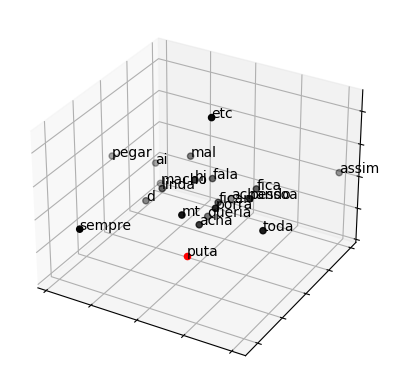

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold
fig = plt.figure()

word = 'puta'

# word embedding
tot_words = [word] + [tupla[0] for tupla in
                      nlp.wv.most_similar(word, topn=20)]
X = nlp.wv[tot_words]
# pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=10, n_components=3, init='pca')
X = pca.fit_transform(X)
# create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x", "y", "z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
# plot 3d
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"] == 0]['x'],
           dtf_[dtf_["input"] == 0]['y'],
           dtf_[dtf_["input"] == 0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"] == 1]['x'],
           dtf_[dtf_["input"] == 1]['y'],
           dtf_[dtf_["input"] == 1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[],
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x", "y", "z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)


In [16]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [17]:
word = "data"
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 2179 |idx
embeddings[idx]: (300,) |vector


In [18]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

2022-10-01 18:04:22.037983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 300)      3313200     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 15)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 15)      240         ['permute[0][0]']                
                                                                                              

In [19]:
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

/home/kunumi/miniconda3/envs/hate-seepch/lib/python3.8/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


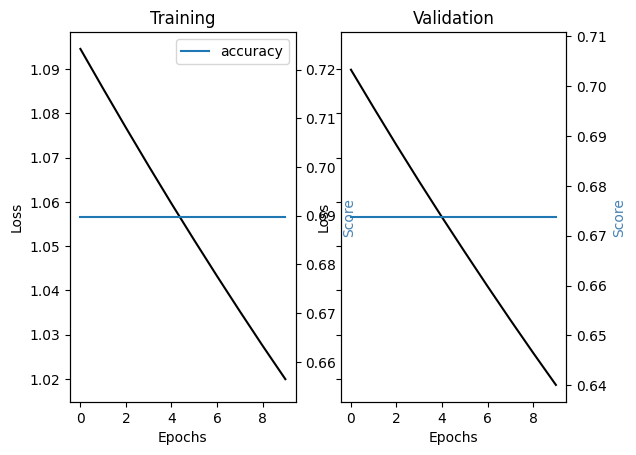

In [20]:
# plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k)
           and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
    ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()
